/var/folders/b7/1tvk5qmx0ds9c6gk2lrlhv380000gn/T/ipykernel_34512/2909104732.py:17: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  result = minimize(mlogl, initial_guess, args=(x,), jac=False, hess=True, options={'disp': True})


Optimization terminated successfully.
         Current function value: 117.413542
         Iterations: 2
         Function evaluations: 8
         Gradient evaluations: 4

Results:
True Value     Estimate       StdErr         Z-Stat         P-Value        95% CI         
5.0000         5.2326         5.9016         0.0394         0.9686         [-6.3345, 16.7996]


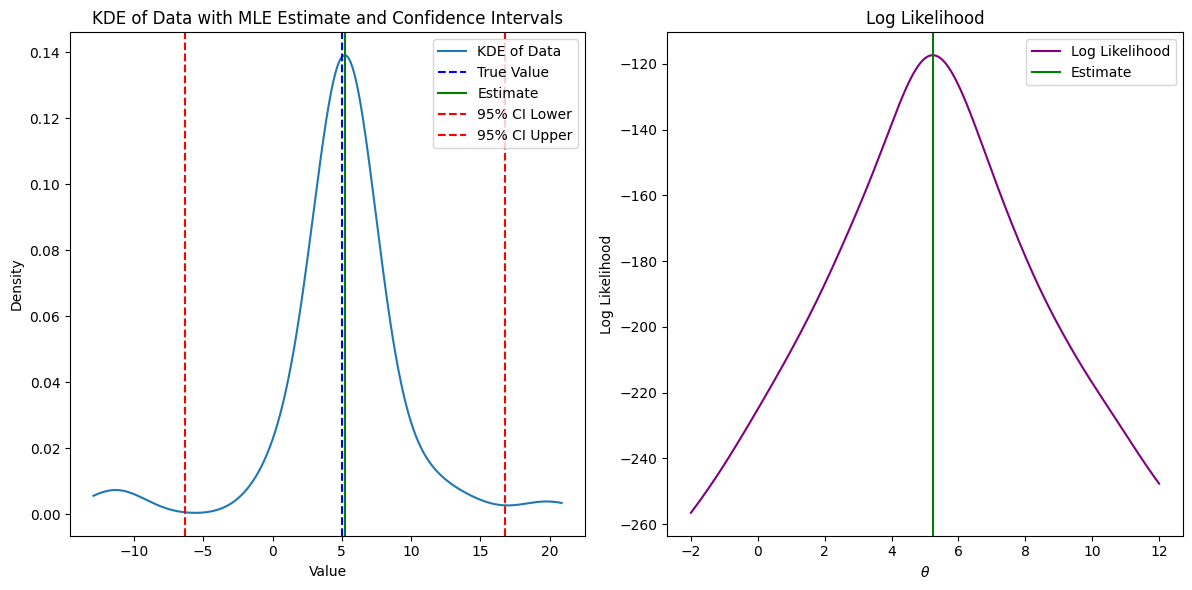

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy, norm, gaussian_kde
from scipy.optimize import minimize

# Simulate or load data (similar to R's "read.table")
# In this case, let's simulate data
np.random.seed(0)  # For reproducibility
x = 5 + cauchy.rvs(size=50)

# Function to calculate the negative log-likelihood
def mlogl(theta, x):
    return -np.sum(cauchy.logpdf(x, loc=theta))

# Estimate the MLE using scipy's minimize
initial_guess = np.median(x)  # Use the median as an initial guess
result = minimize(mlogl, initial_guess, args=(x,), jac=False, hess=True, options={'disp': True})

# Extract results
minimum = result.fun
estimate = result.x[0]
hessian = result.hess_inv if result.hess_inv is not None else 'Hessian not available'
gradient = result.jac if result.jac is not None else 'Gradient not available'

# Standard error, z-statistic, p-value, and confidence interval
true_value = 5
info = result.hess_inv if isinstance(result.hess_inv, np.ndarray) else np.array([[1]])
stderr = np.sqrt(1 / info[0, 0]) if isinstance(info, np.ndarray) else None
conf_level = 0.95
crit = norm.ppf((1 + conf_level) / 2)
ci_lower = estimate - crit / np.sqrt(info[0, 0]) if stderr else None
ci_upper = estimate + crit / np.sqrt(info[0, 0]) if stderr else None
z_stat = (estimate - true_value) / stderr if stderr else None
p_value = 2 * (1 - norm.cdf(abs(z_stat))) if z_stat else None

# Print results as a table
print("\nResults:")
print(f"{'True Value':<15}{'Estimate':<15}{'StdErr':<15}{'Z-Stat':<15}{'P-Value':<15}{'95% CI':<15}")
print(f"{true_value:<15.4f}{estimate:<15.4f}{stderr:<15.4f}{z_stat:<15.4f}{p_value:<15.4f}[{ci_lower:.4f}, {ci_upper:.4f}]")

# Plot the KDE and vertical bars for the true value, estimate, and 95% CIs
kde = gaussian_kde(x)
x_range = np.linspace(min(x) - 1, max(x) + 1, 1000)

# Define function for log-likelihood values for plotting
def fred(theta):
    return -np.array([mlogl(t, x) for t in theta])

loglik_x = np.linspace(-2, 12, 1000)
loglik_y = fred(loglik_x)

plt.figure(figsize=(18, 6))

# KDE Plot
plt.subplot(1, 3, 1)
plt.plot(x_range, kde(x_range), label="KDE of Data")
plt.axvline(true_value, color="blue", linestyle="--", label="True Value")
plt.axvline(estimate, color="green", linestyle="-", label="Estimate")
plt.axvline(ci_lower, color="red", linestyle="--", label="95% CI Lower")
plt.axvline(ci_upper, color="red", linestyle="--", label="95% CI Upper")
plt.title("KDE of Data with MLE Estimate and Confidence Intervals")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Log-Likelihood Plot
plt.subplot(1, 3, 2)
plt.plot(loglik_x, loglik_y, label="Log Likelihood", color="purple")
plt.axvline(estimate, color="green", linestyle="-", label="Estimate")
plt.title("Log Likelihood")
plt.xlabel(r"$\theta$")
plt.ylabel("Log Likelihood")
plt.legend()

plt.tight_layout()
plt.show()



Results for Cauchy model:
Theta hat: 5.232567
Vhat (Sandwich): 21.515512
Jhat: 34.819906
Sandwich Confidence Interval: [4.971473, 5.493661]
Regular StdErr: 0.169467
Regular Confidence Interval: [4.900417, 5.564717]

Results for Normal model:
Theta hat: 4.746072
Vhat (Sandwich): 30.970595
Jhat: 35.997668
Sandwich Confidence Interval: [4.443067, 5.049076]
Regular StdErr: 0.166672
Regular Confidence Interval: [4.419400, 5.072743]


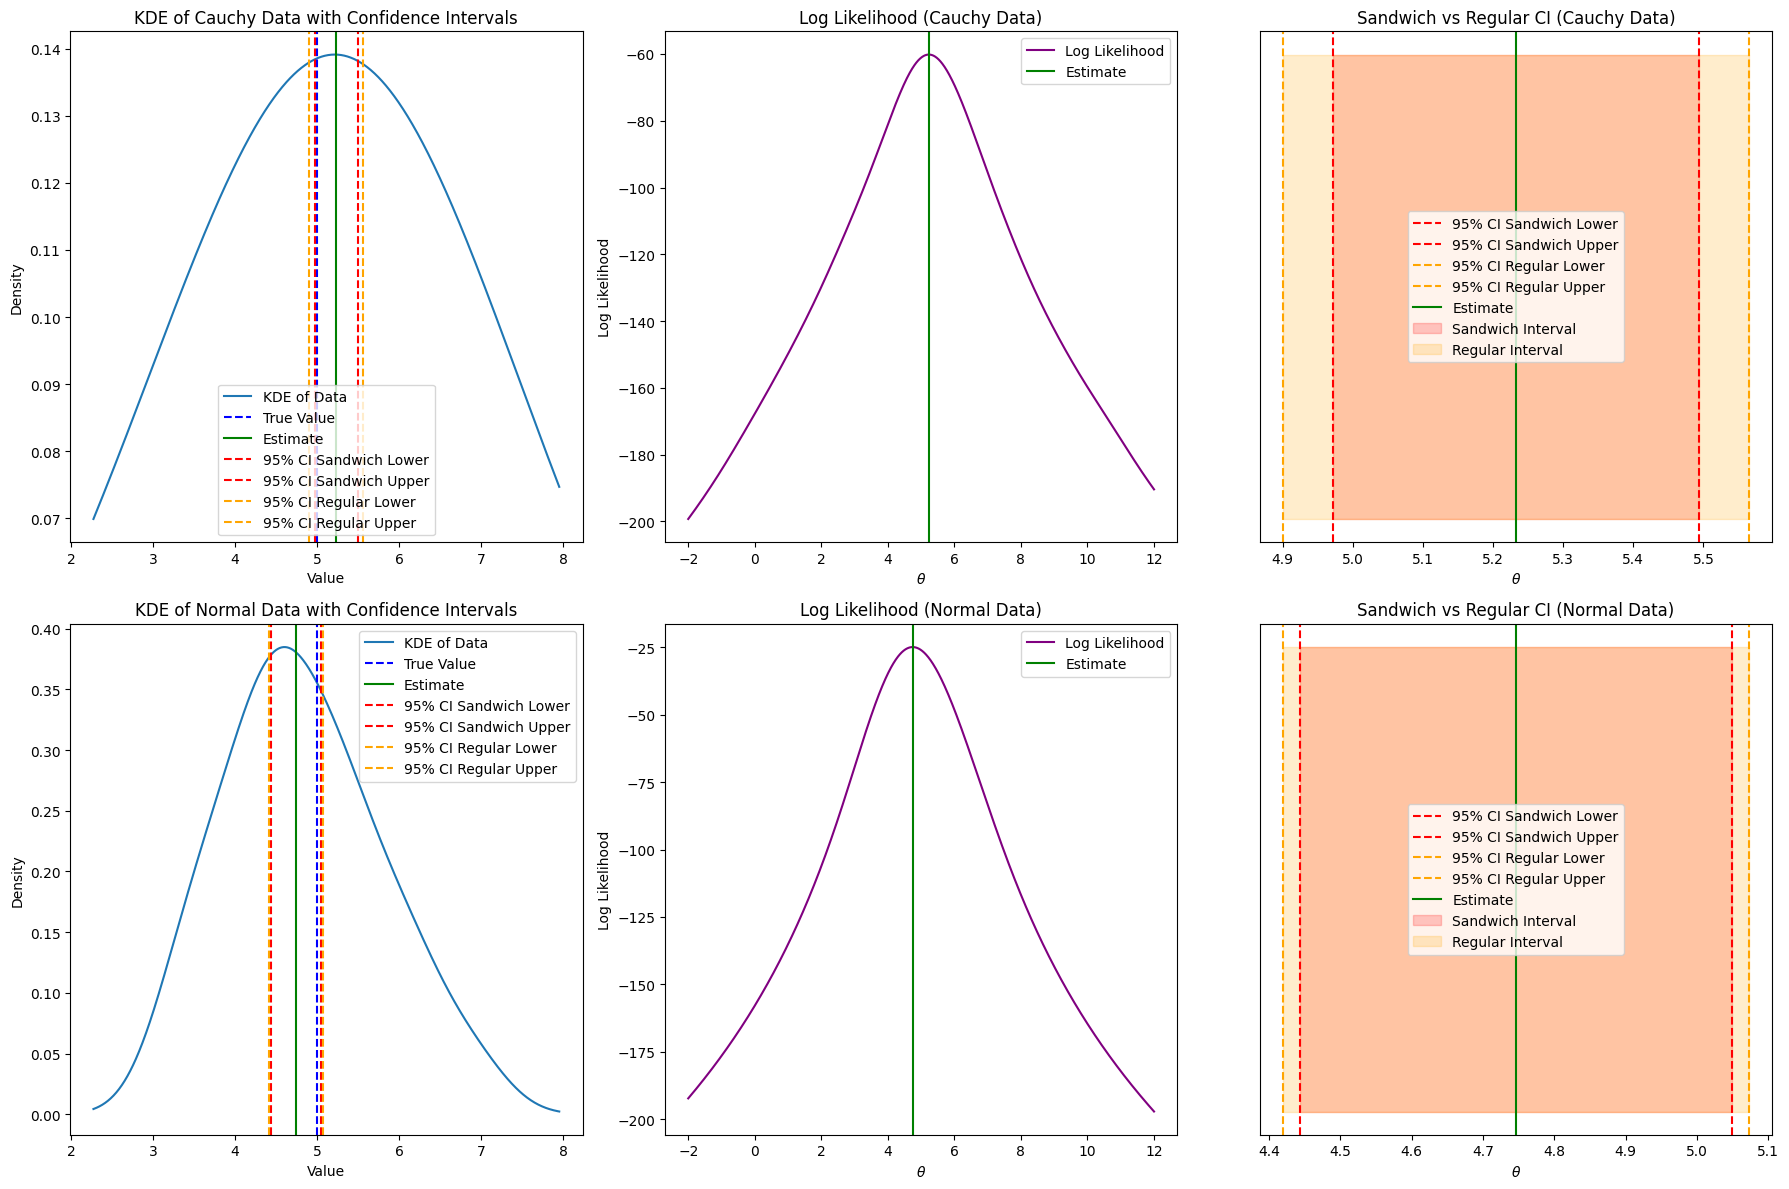

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import cauchy, norm, gaussian_kde
from scipy.optimize import minimize

def simulate_data(distribution, size, true_value):
    if distribution == "cauchy":
        return true_value + cauchy.rvs(size=size)
    elif distribution == "normal":
        return true_value + norm.rvs(size=size)

# Log likelihood and its derivatives
def logl(theta, x):
    return -np.log(1 + (x - theta)**2)

def scor(theta, x):
    return 2 * (x - theta) / (1 + (x - theta)**2)

def hess(theta, x):
    return -(2 / (1 + (x - theta)**2) - 2 * (x - theta) * scor(theta, x) / (1 + (x - theta)**2))

def mloglfun(theta, x):
    return -np.sum(logl(theta, x))

def gradfun(theta, x):
    return -np.sum(scor(theta, x))

def vfun(theta, x):
    return np.sum(scor(theta, x)**2)

def jfun(theta, x):
    return -np.sum(hess(theta, x))

def calculate_intervals(data, model_name):
    # MLE using exact gradient
    out = minimize(mloglfun, np.median(data), args=(data,), jac=gradfun, method='BFGS')

    theta_hat = out.x[0]
    Vhat = vfun(theta_hat, data)
    Jhat = jfun(theta_hat, data)

    # Confidence interval using sandwich estimator
    conf_level = 0.95
    crit = norm.ppf((1 + conf_level) / 2)
    ci_lower_sandwich = theta_hat - crit * np.sqrt(Vhat / Jhat**2)
    ci_upper_sandwich = theta_hat + crit * np.sqrt(Vhat / Jhat**2)

    # Regular standard errors and confidence interval
    stderr_regular = 1 / np.sqrt(Jhat)
    ci_lower_regular = theta_hat - crit * stderr_regular
    ci_upper_regular = theta_hat + crit * stderr_regular

    print(f"\nResults for {model_name} model:")
    print(f"Theta hat: {theta_hat:.6f}")
    print(f"Vhat (Sandwich): {Vhat:.6f}")
    print(f"Jhat: {Jhat:.6f}")
    print(f"Sandwich Confidence Interval: [{ci_lower_sandwich:.6f}, {ci_upper_sandwich:.6f}]")
    print(f"Regular StdErr: {stderr_regular:.6f}")
    print(f"Regular Confidence Interval: [{ci_lower_regular:.6f}, {ci_upper_regular:.6f}]")

    return theta_hat, ci_lower_sandwich, ci_upper_sandwich, ci_lower_regular, ci_upper_regular

# Case 1: Data from Cauchy, Model is Cauchy
np.random.seed(0)  # For reproducibility
true_value = 5
size = 50

x_cauchy = simulate_data("cauchy", size, true_value)
x_range = np.linspace(min(x_cauchy) - 1, max(x_cauchy) + 1, 1000)

theta_hat_cauchy, ci_lower_sandwich_cauchy, ci_upper_sandwich_cauchy, ci_lower_regular_cauchy, ci_upper_regular_cauchy = calculate_intervals(x_cauchy, "Cauchy")

# Case 2: Data from Normal, Model is Cauchy
x_normal = simulate_data("normal", size, true_value)
x_range = np.linspace(min(x_normal) - 1, max(x_normal) + 1, 1000)

theta_hat_normal, ci_lower_sandwich_normal, ci_upper_sandwich_normal, ci_lower_regular_normal, ci_upper_regular_normal = calculate_intervals(x_normal, "Normal")

# KDE and Log-Likelihood Plots for Both Cases
plt.figure(figsize=(18, 12))

# KDE Plot for Cauchy Data
plt.subplot(2, 3, 1)
kde_cauchy = gaussian_kde(x_cauchy)
plt.plot(x_range, kde_cauchy(x_range), label="KDE of Data")
plt.axvline(true_value, color="blue", linestyle="--", label="True Value")
plt.axvline(theta_hat_cauchy, color="green", linestyle="-", label="Estimate")
plt.axvline(ci_lower_sandwich_cauchy, color="red", linestyle="--", label="95% CI Sandwich Lower")
plt.axvline(ci_upper_sandwich_cauchy, color="red", linestyle="--", label="95% CI Sandwich Upper")
plt.axvline(ci_lower_regular_cauchy, color="orange", linestyle="--", label="95% CI Regular Lower")
plt.axvline(ci_upper_regular_cauchy, color="orange", linestyle="--", label="95% CI Regular Upper")
plt.title("KDE of Cauchy Data with Confidence Intervals")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Log-Likelihood Plot for Cauchy Data
loglik_x = np.linspace(-2, 12, 1000)
loglik_y_cauchy = np.array([-mloglfun(t, x_cauchy) for t in loglik_x])
plt.subplot(2, 3, 2)
plt.plot(loglik_x, loglik_y_cauchy, label="Log Likelihood", color="purple")
plt.axvline(theta_hat_cauchy, color="green", linestyle="-", label="Estimate")
plt.title("Log Likelihood (Cauchy Data)")
plt.xlabel(r"$\theta$")
plt.ylabel("Log Likelihood")
plt.legend()

# Sandwich vs Regular Confidence Interval for Cauchy Data
plt.subplot(2, 3, 3)
plt.axvline(ci_lower_sandwich_cauchy, color="red", linestyle="--", label="95% CI Sandwich Lower")
plt.axvline(ci_upper_sandwich_cauchy, color="red", linestyle="--", label="95% CI Sandwich Upper")
plt.axvline(ci_lower_regular_cauchy, color="orange", linestyle="--", label="95% CI Regular Lower")
plt.axvline(ci_upper_regular_cauchy, color="orange", linestyle="--", label="95% CI Regular Upper")
plt.axvline(theta_hat_cauchy, color="green", linestyle="-", label="Estimate")
plt.fill_betweenx([0, 1], ci_lower_sandwich_cauchy, ci_upper_sandwich_cauchy, color="red", alpha=0.2, label="Sandwich Interval")
plt.fill_betweenx([0, 1], ci_lower_regular_cauchy, ci_upper_regular_cauchy, color="orange", alpha=0.2, label="Regular Interval")
plt.title("Sandwich vs Regular CI (Cauchy Data)")
plt.xlabel(r"$\theta$")
plt.yticks([])
plt.legend()

# KDE Plot for Normal Data
plt.subplot(2, 3, 4)
kde_normal = gaussian_kde(x_normal)
plt.plot(x_range, kde_normal(x_range), label="KDE of Data")
plt.axvline(true_value, color="blue", linestyle="--", label="True Value")
plt.axvline(theta_hat_normal, color="green", linestyle="-", label="Estimate")
plt.axvline(ci_lower_sandwich_normal, color="red", linestyle="--", label="95% CI Sandwich Lower")
plt.axvline(ci_upper_sandwich_normal, color="red", linestyle="--", label="95% CI Sandwich Upper")
plt.axvline(ci_lower_regular_normal, color="orange", linestyle="--", label="95% CI Regular Lower")
plt.axvline(ci_upper_regular_normal, color="orange", linestyle="--", label="95% CI Regular Upper")
plt.title("KDE of Normal Data with Confidence Intervals")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()

# Log-Likelihood Plot for Normal Data
loglik_y_normal = np.array([-mloglfun(t, x_normal) for t in loglik_x])
plt.subplot(2, 3, 5)
plt.plot(loglik_x, loglik_y_normal, label="Log Likelihood", color="purple")
plt.axvline(theta_hat_normal, color="green", linestyle="-", label="Estimate")
plt.title("Log Likelihood (Normal Data)")
plt.xlabel(r"$\theta$")
plt.ylabel("Log Likelihood")
plt.legend()

# Sandwich vs Regular Confidence Interval for Normal Data
plt.subplot(2, 3, 6)
plt.axvline(ci_lower_sandwich_normal, color="red", linestyle="--", label="95% CI Sandwich Lower")
plt.axvline(ci_upper_sandwich_normal, color="red", linestyle="--", label="95% CI Sandwich Upper")
plt.axvline(ci_lower_regular_normal, color="orange", linestyle="--", label="95% CI Regular Lower")
plt.axvline(ci_upper_regular_normal, color="orange", linestyle="--", label="95% CI Regular Upper")
plt.axvline(theta_hat_normal, color="green", linestyle="-", label="Estimate")
plt.fill_betweenx([0, 1], ci_lower_sandwich_normal, ci_upper_sandwich_normal, color="red", alpha=0.2, label="Sandwich Interval")
plt.fill_betweenx([0, 1], ci_lower_regular_normal, ci_upper_regular_normal, color="orange", alpha=0.2, label="Regular Interval")
plt.title("Sandwich vs Regular CI (Normal Data)")
plt.xlabel(r"$\theta$")
plt.yticks([])
plt.legend()

plt.tight_layout()
plt.show()
